# Explorer le jeu de données métier

## Préparer l'environnement de travail

In [2]:
# import des outils
import pandas as pd
import numpy as np
import pandas_profiling as pd_prof
import matplotlib as plot
import matplotlib.font_manager
from matplotlib import pyplot as plt
%matplotlib inline
import string
from datetime import datetime, date, timedelta, timezone


In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.decomposition import factor_analysis
from mca import MCA

In [4]:
from sklearn.svm import OneClassSVM

## Les données

** Les données sont issues de journaux d'activité de firewalls. 
On parle de "flux de données".
Parmi les colonnes disponibles dans le flux brut, j'ai choisi de conserver les colonnes les plus fournies (peu ou pas de manquants) et les moins redondantes. **
+ Time : horodatage
+ Action : Drop, Accept : action du firewall pour autoriser le flux ou non
+ Source : adresse IP initriatrice du flux observé
+ Destination : adresse IP destinatrice du flux
+ Service Name : associé au port destination.
+ Attack Name : Dans certains cas le firewall a identifié un flux intrusif. Cette colonne est la variable à prédire. 

dataSource=pd.read_csv("./BigData/logsExport20180702.csv",usecols=['Time', 'Action',
       'Source','Destination', 'Service Name', 'Attack Name'], dtype=str)

dataOutliers=pd.read_csv("./BigData/TargetDF34.csv",usecols=['Time', 'Action',
       'Source','Destination', 'Service Name', 'Attack Name'], dtype=str)

In [5]:
cols=['Time', 'Action', 'Source','Destination' , 'Service Name', 'Attack Name']

dataOutliers=dataOutliers[cols]

dataSource=dataSource[cols]

dataSource = dataSource.append(dataOutliers, ignore_index=True)

dataSource.shape

print (dataSource.ix[144374])

### Identifier les sources publiques

** La colonne 'Source' représente les adresses IP initiatrices des flux. Seules les adresses "publiques" sont pertinentes dans cette analyse, c'est à dire les adresses routées sur Internet. Ici je choisis de filrer les données pour ne conserver que les adresses IP publiques. Les adresses privées (non routées sur Internet) sont issues du Datacenter et ne présentent pas d'intérêt. **

data=dataSource[(dataSource['Source'].str.contains('^([^192.168.].*)', na=False))]
data=data[(data['Source'].str.contains('^([^0.0.0.0].*)', na=False))]

data.shape

** Transformer la colonne Time en format DateTime **

data['timestamp']=pd.to_datetime(data['Time'], dayfirst=True, format='%d/%b/%Y,%H:%M:%S')
data['Time']=datetime(2018,7,3,0)-data['timestamp']
data=data.drop('timestamp',axis=1)

data.to_csv('./BigData/trainLogs.csv', sep=',', encoding='utf-8')

## je charge le fichier aux données travaillées

In [6]:
data=pd.read_csv('./trainLogs.csv')
#usecols=["Time","Action","Source","Destination", "Service Name", "Attack Name"]

# exploration initiale
## découverte des données

In [7]:
data.head()

,Unnamed: 0,Time,Action,Source,Destination,Service Name,Attack Name
0,15,0 days 10:18:26.000000000,Drop,71.6.146.130,195.8.124.232 (mail.probtp.com),UDP/11211,NaN
1,23,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
2,24,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
3,25,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
4,38,0 days 10:18:27.000000000,Drop,71.6.216.47,185.145.76.52,UDP/623,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15978 entries, 0 to 15977
Data columns (total 7 columns):
Unnamed: 0      15978 non-null int64
Time            15978 non-null object
Action          15978 non-null object
Source          15978 non-null object
Destination     15946 non-null object
Service Name    15847 non-null object
Attack Name     41 non-null object
dtypes: int64(1), object(6)
memory usage: 873.9+ KB


In [9]:
data.columns

Index(['Unnamed: 0', 'Time', 'Action', 'Source', 'Destination', 'Service Name',
       'Attack Name'],
      dtype='object')

In [16]:
data = data.rename(index=str,columns={'Unnamed: 0': "id"})

## Analyse univariée

In [17]:
data["Time"].describe()

count                         15978
unique                         4032
top       0 days 11:16:20.000000000
freq                            260
Name: Time, dtype: object

In [24]:
data["Action"].describe()

count     15978
unique        6
top        Drop
freq      11232
Name: Action, dtype: object

In [25]:
data["Source"].describe()

count            15978
unique            3535
top       46.161.27.30
freq               815
Name: Source, dtype: object

In [26]:
data["Destination"].describe()

count                                 15946
unique                                  556
top       195.8.124.236 (dnsweb.probtp.com)
freq                                   2488
Name: Destination, dtype: object

In [27]:
data["Service Name"].describe()

count          15847
unique           496
top       domain-udp
freq            2472
Name: Service Name, dtype: object

In [28]:
data["Attack Name"].describe()

count                                   41
unique                                   5
top       Web Server Enforcement Violation
freq                                    34
Name: Attack Name, dtype: object

## Analyse bivariée

In [18]:
data[0:]

,id,Time,Action,Source,Destination,Service Name,Attack Name
0,15,0 days 10:18:26.000000000,Drop,71.6.146.130,195.8.124.232 (mail.probtp.com),UDP/11211,NaN
1,23,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
2,24,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
3,25,0 days 10:18:26.000000000,Accept,31.13.112.155,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
4,38,0 days 10:18:27.000000000,Drop,71.6.216.47,185.145.76.52,UDP/623,NaN
5,39,0 days 10:18:27.000000000,Accept,31.13.113.172,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
6,40,0 days 10:18:27.000000000,Accept,31.13.113.172,195.8.124.236 (dnsweb.probtp.com),domain-udp,NaN
7,47,0 days 10:18:27.000000000,Drop,78.85.19.66,185.145.76.97,telnet,NaN
8,79,0 days 10:18:27.000000000,Drop,71.6.216.54,185.145.76.31,UDP/623,NaN
9,91,0 days 10:18:27.000000000,Drop,74.82.47.5,195.8.124.175,UDP/17,NaN


In [ ]:
tableau de contingences 2 à 2

In [30]:
contingenceActionSource = pd.crosstab(index=data["id"], columns=[data["Action"], data["Source"]], margins=True)
contingenceActionDestination = pd.crosstab(index=data["id"], columns=[data["Action"], data["Destination"]], margins=True)
contingenceActionServiceName = pd.crosstab(index=data["id"], columns=[data["Action"], data["Service Name"]], margins=True)
contingenceSourceDestination = pd.crosstab(index=data["id"], columns=[data["Source"], data["Destination"]], margins=True)
contingenceSourceServiceName = pd.crosstab(index=data["id"], columns=[data["Source"], data["Service Name"]], margins=True)
contingenceDestinationServiceName = pd.crosstab(index=data["id"], columns=[data["Destination"], data["Service Name"]], margins=True)

In [28]:
contingence = pd.crosstab(index=data["id"], columns=[data["Action"], data["Source"], data["Destination"]], margins=True)

In [29]:
contingence

Action                                 Accept  \
Source                          31.13.112.155   
Destination 195.8.124.236 (dnsweb.probtp.com)   
id                                              
15                                          0   
23                                          1   
24                                          1   
25                                          1   
38                                          0   
39                                          0   
40                                          0   
47                                          0   
79                                          0   
91                                          0   
92                                          0   
93                                          0   
97                                          0   
104                                         0   
113                                         0   
136                                         0   
163                                         0   
179                                         0   
205                                         0   
236                                         0   
237                                         0   
239                                         0   
250                                         0   
259                                         0   
307                                         0   
371                                         0   
398                                         0   
477                                         0   
482                                         0   
489                                         0   
...                                       ...   
200005                                      0   
200006                                      0   
200007                                      0   
200008                                      0   
200009                                      0   
200010                                      0   
200011                                      0   
200012                                      0   
200013                                      0   
200014                                      0   
200015                                      0   
200016                                      0   
200017                                      0   
200018                                      0   
200019                                      0   
200020                                      0   
200021                                      0   
200022                                      0   
200023                                      0   
200024                                      0   
200025                                      0   
200026                                      0   
200027                                      0   
200028                                      0   
200029                                      0   
200030                                      0   
200031                                      0   
200032                                      0   
200033                                      0   
All                                         3   

Action                                         \
Source                          31.13.112.158   
Destination 195.8.124.236 (dnsweb.probtp.com)   
id                                              
15                                          0   
23                                          0   
24                                          0   
25                                          0   
38                                          0   
39                                          0   
40                                          0   
47                                          0   
79                                          0   
91                                          0   
92                                          1   
93                                          1   
97                            

+ et ensuite ? ...

# Zoom sur les attaques

In [16]:
data.dropna(subset=['Attack Name'])

,Time,Action,Source,Destination,Service Name,Attack Name
9726,10:21:37,Reject,41.226.167.49,185.145.76.171 (www.izilio.com),http,WordPress Enforcement Protection
24164,10:26:44,Drop,37.142.5.63,185.145.76.98 (espace-personnel.agirc-arrco.fr),https,Streaming Engine: TCP Invalid Checksum
30407,10:28:56,Reject,46.243.189.40,NaN,NaN,Security Products Enforcement Violation
36089,10:30:56,Reject,46.243.189.40,195.8.124.222 (pavisxr1-publique),UDP/53413,Security Products Enforcement Violation
66588,10:42:18,Drop,37.173.142.154,185.145.76.138 (www.probtp.com),https,Streaming Engine: TCP Invalid Checksum
89541,10:50:51,Drop,78.221.240.192,185.145.76.174 (www.izilio-btp.fr),https,Streaming Engine: TCP Invalid Checksum
155497,11:14:27,Reject,37.49.231.14,195.8.124.222 (pavisxr1-publique),sip,Scanner Enforcement Violation
200000,12:08:18,Reject,54.37.200.171,185.145.76.140 (services-recmet2.agirc-arrco.fr),http,Web Server Enforcement Violation
200001,12:08:30,Reject,54.37.200.171,185.145.76.98 (espace-personnel.agirc-arrco.fr),http,Web Server Enforcement Violation
200002,12:08:32,Reject,54.37.200.171,185.145.76.182 (www.santeavc.com),http,Web Server Enforcement Violation


In [40]:
data['Attack Name'].value_counts()

Web Server Enforcement Violation           34
Streaming Engine: TCP Invalid Checksum      3
Security Products Enforcement Violation     2
Scanner Enforcement Violation               1
WordPress Enforcement Protection            1
Name: Attack Name, dtype: int64

In [41]:
data['Attaque_DETECTEE']=data['Attack Name'].fillna(value=0)
data['Attaque_DETECTEE']=np.where(data['Attaque_DETECTEE']==0  , 0, 1)

In [42]:
data['Attaque_DETECTEE'].value_counts()

0    15937
1       41
Name: Attaque_DETECTEE, dtype: int64

In [ ]:
#dataOutliers = pd.DataFrame.query(expr='Attaque_DETECTEE == "Web Server Enforcement Violation"', self=data)

In [ ]:
#TargetDF.shape

In [ ]:
#pd.DataFrame.to_csv(TargetDF, path_or_buf='./BigData/TargetDF34.csv')

In [ ]:
#dataACM = pd.DataFrame.query(expr='Attaque_DETECTEE != "Web Server Enforcement Violation"', self=data)

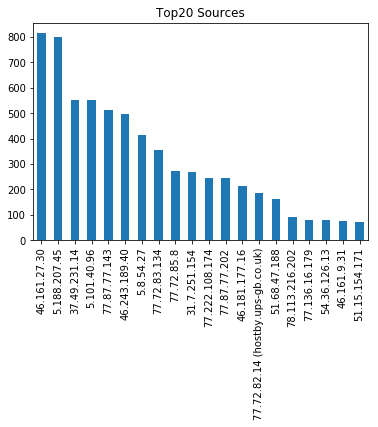

In [31]:
#top20 = np.log10(data["Source"].value_counts())
top20 = data["Source"].value_counts()
top20.sort_values(ascending=False)
top20 = top20[:20]
top20.plot(kind="bar", title='Top20 Sources')

#top20

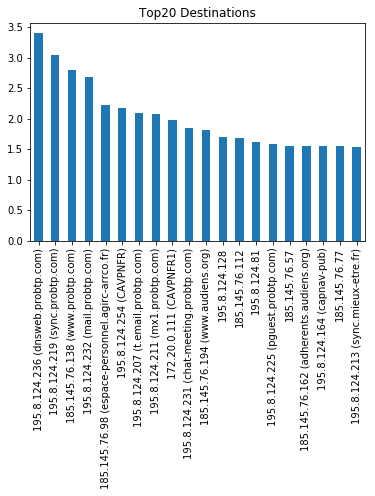

In [32]:
top20 = np.log10(data["Destination"].value_counts())
#top20 = data["Destination"].value_counts()
top20.sort_values(ascending=False)
top20 = top20[:20]
top20.plot(kind="bar", title='Top20 Destinations')

+ exploration via Pandas

In [ ]:
pd_prof.ProfileReport(data)

## appliquer une ACM 

** préparer les données, tableau disjonctif complet pour Source, Destination, Service Name, Rule UID **

In [43]:
dataTDC=data

In [44]:
dataTDC.shape

(15978, 8)

 Construire les Tableaux Disjonctifs Complets pour analyser les variables qualitatives

In [45]:
tdcAction = pd.get_dummies(pd.DataFrame(dataTDC['Action']))
tdcAction.shape

(15978, 6)

In [46]:
tdcSource =  pd.get_dummies(pd.DataFrame(dataTDC['Source']))
tdcSource.shape

(15978, 3535)

In [47]:
tdcDestination =  pd.get_dummies(pd.DataFrame(dataTDC['Destination']))
tdcDestination.shape

(15978, 556)

In [48]:
tdcServiceName =  pd.get_dummies(pd.DataFrame(dataTDC['Service Name']))
tdcServiceName.shape

(15978, 496)

In [49]:
dataTDCfinal=tdcAction.join(tdcSource, how='outer')
dataTDCfinal=dataTDCfinal.join(tdcDestination,how='outer')
dataTDCfinal=dataTDCfinal.join(tdcServiceName,how='outer')
dataTDCfinal=dataTDCfinal.join(data['Attaque_DETECTEE'])

In [50]:
#dataTDCfinal.insert(0,'Time',data['Time'])


In [51]:
dataTDCfinal.head(5)

,Action_Accept,Action_Drop,Action_IP Changed,Action_Key Install,Action_Log Out,Action_Reject,Source_31.10.67.95,Source_31.129.244.96,Source_31.13.112.155,Source_31.13.112.158,...,Service Name_snmp-read,Service Name_sqlnet2-1521,Service Name_squid,Service Name_ssh,Service Name_tcp_8009,Service Name_tcp_8088,Service Name_telnet,Service Name_tftp,Service Name_udp-high-ports,Attaque_DETECTEE
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#https://github.com/esafak/mca/blob/master/docs/usage.rst


** exemple sur un échantillon **

*** Faut-il réduire les données par un tirage aléatoire ? OUI car il y a de trop grandes cardinalités sinon. même en se focalisant sur les sources en adresse IP publiques ***

In [37]:
dataACM = dataTDCfinal.sample(1000)

In [ ]:
dataACM.shape

** comparer la donnée initiale et la donnée transformée **

In [ ]:
print (dataSource.ix[37621])

In [ ]:
print (dataACM.loc[37621])

In [ ]:
#mca_df = mca.MCA(dataframe[, cols=None][, ncols=None][, benzecri=True][, TOL=1e-4])
mca_df = MCA(dataACM)

In [ ]:
#mca_ind = MCA(data,cols=['timeDelta','Source','Destination','Action'], benzecri=False)
mca_ind = MCA(dataACM, benzecri=False)

In [ ]:
#print(mca_counts.fs_r(1)) # 1 = 100%, meaning preserve all variance.
mca_result=mca_df.fs_r(1)
mca_result

In [ ]:
mca_result.shape

In [ ]:
#The eigenvalues, or principal inertias, of the factors:
mca_eigienValues=mca_df.L
mca_eigienValues

In [ ]:
#The inertia is simply the sum of the principle inertias:
print(mca_df.inertia, mca_df.L.sum())

In [ ]:
#Benzécri
print(mca_df.s)

In [ ]:
print(sum(mca_df.s**2))

Tableau indiquant pour chaque variable : 
"Eigenvalues, corrected eigenvalues, proportion of explained inertia and corrected proportion of explained inertia. 
Les eigenvalues de la martice de Burt sont égales au carré des eigenvalues dans la matrice "indicator" ; Les valeurs corrigées eigenvalues pour Benzécri et Greenacre sont les mêmes, mais la proportion de la variance expliquée est différente. Les Eigenvalues sont repérées par le symbole λ, les proportions d'inertie expliquées sont repérées par τ. 

Le champ L présente les eigenvalues, soit les inerties principales, des facteurs. La Méthode expl_var donne la proportion de l'inertie expliquée pour chaque facteur, tandis que les corrections Greenacre (activées par les paramètres Greenacre=True et N) limitent le nombre de facteurs retenus.

In [ ]:
dfACM = {'Iλ': pd.Series(mca_ind.L),
        'τI': mca_ind.expl_var(greenacre=False, N=848),
        'Zλ': pd.Series(mca_eigienValues),
        'τZ': mca_df.expl_var(greenacre=False, N=848),
        'cλ': pd.Series(mca_eigienValues),
        'τc': mca_ind.expl_var(greenacre=True, N=848)}

# 'Indicator Matrix', 'Benzecri Correction', 'Greenacre Correction'
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=dfACM, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Facteur'

table2

In [ ]:
dataTab3 = np.array([mca_df.L[:2], 
                 mca_df.expl_var(greenacre=True, N=2) * 100]).T
df = pd.DataFrame(data=dataTab3, columns=['cλ','%c'], index=range(1,3))
df

In [ ]:
fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
table3 = pd.DataFrame(columns=dataACM.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))

table3.loc[fs,    :] = mca_df.fs_r(N=2).T
table3.loc[cos,   :] = mca_df.cos_r(N=2).T
table3.loc[cont,  :] = mca_df.cont_r(N=2).T * 1000

np.round(table3.astype(float), 2)

+ représentation graphique de l'ACM

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

points = table3.loc[fs].values
labels = table3.columns.values

plt.figure()
plt.margins(0.1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter(*points, s=12, marker='o', c='darkblue', alpha=.5,linewidths=0)
#for label, x, y in zip(labels, *points):
 #   plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
plt.show()

# Appliquer le SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
x_train = dataTDC

In [ ]:
y_train = data['Attaque_DETECTEE']

In [ ]:
modele_svm=SVC()

In [ ]:
modele_svm.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
x_train_train,x_train_test, y_train_train,y_train_test = train_test_split(x_train,
                                                                         y_train,
                                                                         test_size=0.2)

In [ ]:
y_train_test.value_counts()

In [ ]:
y_train_train.value_counts()

In [ ]:
modele_svm_valid=SVC(C=1)
modele_svm_valid.fit(x_train_train,y_train_train)

In [ ]:
y_modele_pred=modele_svm_valid.predict(x_train_test)
y_modele_pred

In [ ]:
confusion_matrix(y_train_test,y_modele_pred)

In [ ]:
accuracy_score(y_train_test,y_modele_pred)

In [ ]:
recall_score(y_train_test,y_modele_pred)

In [ ]:
roc_auc_score(y_train_test,y_modele_pred)

In [ ]:
precision_score(y_train_test,y_modele_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
dico_param={"kernel":["linear","rbf",], "C":[1,5]}

In [ ]:
modele_svm_grid=GridSearchCV(SVC(),dico_param,scoring='accuracy',cv=5)
modele_svm_grid

In [ ]:
modele_svm_grid.fit(x_train,y_train)

In [ ]:
modele_svm_grid.best_estimator_

# Appliquer le SVM à classe unique

** Le modèle SVM à classe unique est spécialement conçu pour détecter les anomalies (outliers)
dans un ensemble de données dites normales. **

## Réglage des paramètres

* noyau RBF : j'utilise un noyau non linéraire car il n'y a pas de classes à séparer.
* gamma : 1 par défaut, pour démarrer
* nu : 

In [33]:
modelOneClass = OneClassSVM(kernel='rbf', gamma=1, nu=0.1)

** Je sépare données relatives aux attaques avérées **

In [38]:
X_Outliers = dataTDCfinal[dataTDCfinal['Attaque_DETECTEE']==1]
X_Outliers.shape

(41, 4594)

** Je sépare les données restantes en deux jeux, l'un pour l'apprentissage, l'autre pour les tests **

In [39]:
X=dataTDCfinal[dataTDCfinal['Attaque_DETECTEE']==0].sample(10000)
X.shape

(10000, 4594)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
(X_train,X_test)=train_test_split(X, test_size=0.33)

In [42]:
X_train.shape

(6700, 4594)

In [43]:
X_test.shape

(3300, 4594)

** Je crée le modèle OneClassSVM **

In [44]:
modelOneClass.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

** J'applique le modèle au jeu d'apprentissage **

In [ ]:
y_pred_train = modelOneClass.predict(X_train)

** J'applique le modèle au jeu d'apprentissage **

In [ ]:
y_pred_test = modelOneClass.predict(X_test)

** J'applique le modèle sur le jeu de données "Attaque_Detectee" ** 

In [ ]:
y_pred_outliers = modelOneClass.predict(X_Outliers)

** J'estime les erreurs en comparant les predictions **

In [ ]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_train

In [ ]:
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_test

In [ ]:
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
n_error_outliers

# préparer une matrice meshgrid pour la représentation graphique
Problème : comment peupler cette matrice de dimension (10000,4594) en remplissant chaque colonne par un gradient linéaire de valeurs allant de -1 à +1 ?

In [ ]:
#exemple pour une matrice 10000*2 xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
#np.c_[xx.ravel(), yy.ravel()]

In [46]:
valuesMesh=np.zeros(shape=(X.shape))

In [70]:
dfMesh = pd.DataFrame(valuesMesh)
dfMesh.shape

(10000, 4594)

In [71]:
dfMesh[1]=np.linspace(-1,1,10000)
dfMesh[1]

0      -1.000000
1      -0.999800
2      -0.999600
3      -0.999400
4      -0.999200
5      -0.999000
6      -0.998800
7      -0.998600
8      -0.998400
9      -0.998200
10     -0.998000
11     -0.997800
12     -0.997600
13     -0.997400
14     -0.997200
15     -0.997000
16     -0.996800
17     -0.996600
18     -0.996400
19     -0.996200
20     -0.996000
21     -0.995800
22     -0.995600
23     -0.995400
24     -0.995200
25     -0.994999
26     -0.994799
27     -0.994599
28     -0.994399
29     -0.994199
          ...   
9970    0.994199
9971    0.994399
9972    0.994599
9973    0.994799
9974    0.994999
9975    0.995200
9976    0.995400
9977    0.995600
9978    0.995800
9979    0.996000
9980    0.996200
9981    0.996400
9982    0.996600
9983    0.996800
9984    0.997000
9985    0.997200
9986    0.997400
9987    0.997600
9988    0.997800
9989    0.998000
9990    0.998200
9991    0.998400
9992    0.998600
9993    0.998800
9994    0.999000
9995    0.999200
9996    0.999400
9997    0.9996

In [72]:
for i in range (2, 4594) : dfMesh[i] = dfMesh[1] 

In [68]:
dfMesh

,0,1,2,3,4,5,6,7,8,9,...,4944,4945,4946,4947,4948,4949,4950,4951,4952,4953
0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.0,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,...,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800,-0.999800
2,0.0,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,...,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600,-0.999600
3,0.0,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,...,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400,-0.999400
4,0.0,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,...,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200,-0.999200
5,0.0,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,...,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000,-0.999000
6,0.0,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,...,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800,-0.998800
7,0.0,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,...,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600,-0.998600
8,0.0,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,...,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400,-0.998400
9,0.0,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,...,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200,-0.998200


In [73]:
Z = modelOneClass.decision_function(dfMesh)

In [74]:
Z.shape

(10000, 1)

In [ ]:
Z = Z.reshape(xx.shape)
Z.shape

In [78]:
Z.min()

-1.9817878389763888

In [79]:
Z.max()

10.696256600672422

In [ ]:
np.c_[xx.ravel(), yy.ravel()].shape

In [ ]:
xx.ravel().shape

# Visualiser les résultats

In [ ]:
plt.title("Détection d'anomalies dans un flux réseau")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 10
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_Outliers[:, 0], X_Outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.legend([a.collections[0], b1, b2, c],
           ["limite apprise", "jeu d'apprentissage",
            "nouvelles donnes 'normales'", "nouvelles donnes 'anormales'"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "Erreur apprentissage: %d/200 ; Erreurs nouvelles données normales: %d/40 ; "
    "Erreurs nouvelles données anormales: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()


## Appliquer le modèle sur un jeu de données neuf

In [ ]:
  #dataSource=pd.read_csv("./BigData/logsExport20180131-1.csv",usecols=['Time', 'Interface Name', 'Interface Direction', 'Action',
 #      'Source','Destination', 'Origin', 'Out-Zone', 'Protocol', 'Rule UID',
  #     'Source Port', 'Destination Port', 'Service Name', 'Attack Name'], dtype=str)

In [ ]:
#geolocaliser chaque adresse #max 1000/jour
#curl https://ipinfo.io/5.39.220.63?token=e6a64604d8752b